# Breweries EDA
High-level walkthrough of the brewery dataset: load the raw files, clean them up, enrich with population context, and then visualize what we find.


## Setup
Import the pandas/NumPy stack along with folium for mapping, tqdm for progress bars, and scikit-learn pieces for fuzzy matching.


In [335]:
import re
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import folium
from folium.plugins import HeatMap
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

## Brewery Data
Load the Open Brewery DB export, inspect the structure, and trim out brewery types that would skew the analysis (closed, planning, large). See https://www.openbrewerydb.org/ for further documentation.

In [336]:
# load the raw brewery data
BREWERY_PATH = Path('data/united_states_breweries.csv')
df_raw = pd.read_csv(BREWERY_PATH)
df_raw.head()


id                     name brewery_type  \
0  5128df48-79fc-4f0f-8b52-d06be54d0cec         (405) Brewing Co        micro   
1  9c5a66c8-cc13-416f-a5d9-0a769c87d318         (512) Brewing Co        micro   
2  34e8c68b-6146-453f-a4b9-1f6cd99a5ada  1 of Us Brewing Company        micro   
3  6d14b220-8926-4521-8d19-b98a2d6ec3db     10 Barrel Brewing Co        large   
4  e2e78bd8-80ff-4a61-a65c-3bfbd9d76ce2     10 Barrel Brewing Co        large   

                     address_1 address_2  address_3            city  \
0               1716 Topeka St       NaN        NaN          Norman   
1        407 Radam Ln Ste F200       NaN        NaN          Austin   
2          8100 Washington Ave       NaN        NaN  Mount Pleasant   
3                62970 18th St       NaN        NaN            Bend   
4  1135 NW Galveston Ave Ste B       NaN        NaN            Bend   

  state_province postal_code        country   longitude   latitude  \
0       Oklahoma  73069-8224  United States  -97.468182  35.257389   
1          Texas  78745-1197  United States         NaN        NaN   
2      Wisconsin  53406-3920  United States  -87.883364  42.720108   
3         Oregon  97701-9847  United States -121.281706  44.086835   
4         Oregon  97703-2465  United States -121.328802  44.057565   

        phone                   website_url      state  \
0  4058160490     http://www.405brewing.com   Oklahoma   
1  5129211545     http://www.512brewing.com      Texas   
2  2624847553  https://www.1ofusbrewing.com  Wisconsin   
3  5415851007       http://www.10barrel.com     Oregon   
4  5415851007                           NaN     Oregon   

                        street  
0               1716 Topeka St  
1        407 Radam Ln Ste F200  
2          8100 Washington Ave  
3                62970 18th St  
4  1135 NW Galveston Ave Ste B

In [337]:
# filter out types we don't want in the analysis
EXCLUDED_TYPES = {'closed', 'planning', 'large'}
type_mask = df_raw['brewery_type'].str.lower().isin(EXCLUDED_TYPES)
removed_type_count = int(type_mask.sum())
df_clean = df_raw.loc[~type_mask].copy()
print(f'Removed {removed_type_count} breweries with types: {sorted(EXCLUDED_TYPES)}')
df_clean.head()

Removed 993 breweries with types: ['closed', 'large', 'planning']


id                            name  \
0   5128df48-79fc-4f0f-8b52-d06be54d0cec                (405) Brewing Co   
1   9c5a66c8-cc13-416f-a5d9-0a769c87d318                (512) Brewing Co   
2   34e8c68b-6146-453f-a4b9-1f6cd99a5ada         1 of Us Brewing Company   
10  1ecc330f-6275-42a5-b14e-00adbed62752  10 Torr Distilling and Brewing   
11  7531dbd8-afc9-4b5b-95bc-7ece7f2c0bf3           10-56 Brewing Company   

   brewery_type              address_1 address_2  address_3            city  \
0         micro         1716 Topeka St       NaN        NaN          Norman   
1         micro  407 Radam Ln Ste F200       NaN        NaN          Austin   
2         micro    8100 Washington Ave       NaN        NaN  Mount Pleasant   
10        micro            490 Mill St       NaN        NaN            Reno   
11        micro          400 Brown Cir       NaN        NaN            Knox   

   state_province postal_code        country   longitude   latitude  \
0        Oklahoma  73069-8224  United States  -97.468182  35.257389   
1           Texas  78745-1197  United States         NaN        NaN   
2       Wisconsin  53406-3920  United States  -87.883364  42.720108   
10         Nevada       89502  United States -119.773201  39.517170   
11        Indiana       46534  United States  -86.627954  41.289715   

         phone                   website_url      state                 street  
0   4058160490     http://www.405brewing.com   Oklahoma         1716 Topeka St  
1   5129211545     http://www.512brewing.com      Texas  407 Radam Ln Ste F200  
2   2624847553  https://www.1ofusbrewing.com  Wisconsin    8100 Washington Ave  
10  7755307014         http://www.10torr.com     Nevada            490 Mill St  
11  6308165790                           NaN    Indiana          400 Brown Cir

## Population Data
Ingest the Census spreadsheet, flatten the multi-row headers, and isolate rank, city, state, and the 2024 population estimate so we can join it to the brewery counts. See https://www.census.gov/data/tables/time-series/demo/popest/2020s-total-cities-and-towns.html for further documentation.


In [338]:
POPULATION_PATH = Path('data/SUB-IP-EST2024-ANNRNK.xlsx')

def load_population_data(path: Path) -> pd.DataFrame:
# flatten the excel headers
    population_raw = pd.read_excel(
        path,
        skiprows=2,
        header=[0, 1],
        engine='openpyxl'
    )

    def flatten_header(col) -> str:
        parts = []
        for value in col:
            if value is None:
                continue
            clean = str(value).replace('\n', ' ').strip()
            if not clean or clean.lower().startswith('unnamed'):
                continue
            parts.append(clean)
        return ' '.join(parts)

    population_raw.columns = [flatten_header(col) for col in population_raw.columns]
    population_raw = population_raw.loc[:, population_raw.columns.str.strip().astype(bool)]

    rank_col = next((col for col in population_raw.columns if col.lower() == 'rank'), None)
    area_col = next((col for col in population_raw.columns if col.lower() == 'geographic area'), None)
    pop_2024_col = next((col for col in population_raw.columns if '2024' in col and 'population estimate' in col.lower()), None)
    if None in {rank_col, area_col, pop_2024_col}:
        raise ValueError('Expected columns not found in population workbook headers.')

    population_df = population_raw[[rank_col, area_col, pop_2024_col]].copy()
    population_df = population_df.loc[population_df[rank_col].notna()]
    population_df[rank_col] = pd.to_numeric(population_df[rank_col], errors='coerce')
    population_df = population_df.loc[population_df[rank_col].notna()]
    population_df[pop_2024_col] = pd.to_numeric(population_df[pop_2024_col], errors='coerce')
    population_df = population_df.loc[population_df[pop_2024_col].notna()]

    city_state = population_df[area_col].str.rsplit(',', n=1, expand=True)
    population_df['city'] = city_state[0].str.strip()
    population_df['state'] = city_state[1].str.strip() if city_state.shape[1] > 1 else ''
    population_df = population_df.loc[population_df['city'].ne('') & population_df['state'].ne('')]

    population_df = population_df.rename(columns={
        rank_col: 'Rank',
        pop_2024_col: 'Population 2024'
    })
    population_df = population_df[['Rank', 'city', 'state', 'Population 2024']].reset_index(drop=True)
    population_df['Population 2024'] = population_df['Population 2024'].astype(int)
    return population_df

# load the population table for matching
population_df = load_population_data(POPULATION_PATH)
population_df.head()


Rank              city       state  Population 2024
0   1.0     New York city    New York          8478072
1   2.0  Los Angeles city  California          3878704
2   3.0      Chicago city    Illinois          2721308
3   4.0      Houston city       Texas          2390125
4   5.0      Phoenix city     Arizona          1673164

## Breweries per City
Compute brewery counts at the city/state level, normalize city names, and line them up with the population table so each count has a population baseline.


### TF-IDF city matching
Apply a TF-IDF nearest-neighbour match so every brewery location is paired with the closest population record when the names do not align exactly.


In [339]:
# tf-idf helper to get the closest census label when an exact match doesn't exist
MIN_MATCH_SCORE = 0.6

def _normalize_text(value) -> str:
    if pd.isna(value):
        return ''
    text = re.sub(r'[^a-z0-9 ]', ' ', str(value).lower())
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def _normalize_state(value) -> str:
    return _normalize_text(value)

# tf-idf helper to get the closest census label when an exact match doesn't exist
def _tfidf_best_index(target_norm: str, candidate_norms: list[str]):
    if not candidate_norms:
        return None, 0.0
    corpus = [target_norm] + candidate_norms
    vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(3, 5))
    matrix = vectorizer.fit_transform(corpus)
    similarities = linear_kernel(matrix[0:1], matrix[1:]).flatten()
    best_idx = int(similarities.argmax())
    return best_idx, float(similarities[best_idx])

def build_breweries_per_city(population: pd.DataFrame, breweries: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    counts = (
        breweries
        .groupby(['city', 'state'])
        .size()
        .rename('brewery_count')
        .reset_index()
    )
    counts = counts.loc[counts['city'].notna() & counts['state'].notna()].copy()
    counts['city_norm'] = counts['city'].apply(_normalize_text)
    counts['state_norm'] = counts['state'].apply(_normalize_state)

    population_keys = population.copy()
    population_keys['city_norm'] = population_keys['city'].apply(_normalize_text)
    population_keys['state_norm'] = population_keys['state'].apply(_normalize_state)

    pop_by_state = {state: group.reset_index(drop=True) for state, group in population_keys.groupby('state_norm')}

    matches = []
    for row in counts.itertuples(index=False):
        group = pop_by_state.get(row.state_norm)
        if group is None or group.empty:
            matches.append({
                'matched_population_city': None,
                'match_score': 0.0,
                'Population 2024': None,
                'Rank': None
            })
            continue
        exact_match = group.loc[group['city_norm'] == row.city_norm]
        if not exact_match.empty:
            record = exact_match.iloc[0]
            matches.append({
                'matched_population_city': record['city'],
                'match_score': 1.0,
                'Population 2024': int(record['Population 2024']),
                'Rank': int(record['Rank'])
            })
            continue
        best_idx, score = _tfidf_best_index(row.city_norm, group['city_norm'].tolist())
        if best_idx is not None and score >= MIN_MATCH_SCORE:
            record = group.iloc[best_idx]
            matches.append({
                'matched_population_city': record['city'],
                'match_score': score,
                'Population 2024': int(record['Population 2024']) if not pd.isna(record['Population 2024']) else None,
                'Rank': int(record['Rank']) if not pd.isna(record['Rank']) else None
            })
        else:
            matches.append({
                'matched_population_city': None,
                'match_score': float(score if best_idx is not None else 0.0),
                'Population 2024': None,
                'Rank': None
            })

    match_df = counts.join(pd.DataFrame(matches))
    match_df = match_df[['city', 'state', 'brewery_count', 'matched_population_city', 'Population 2024', 'Rank', 'match_score']]
    matched = match_df.loc[match_df['matched_population_city'].notna()].reset_index(drop=True)
    return match_df, matched

# merge brewery counts with population data so we can analyze per city
match_details, breweries_per_city = build_breweries_per_city(population_df, df_clean)
breweries_per_city.head()


city           state  brewery_count matched_population_city  \
0      Aberdeen    South Dakota              1           Aberdeen city   
1       Abilene           Texas              3            Abilene city   
2        Adrian        Michigan              1             Adrian city   
3  Agoura Hills      California              2       Agoura Hills city   
4         Aiken  South Carolina              1              Aiken city   

   Population 2024    Rank  match_score  
0          27919.0  1432.0     0.925572  
1         130501.0   223.0     0.989331  
2          20259.0  1899.0     0.980608  
3          19429.0  1933.0     0.993573  
4          32694.0  1255.0     0.947309

In [340]:
len(breweries_per_city)

1140

### Unmatched brewery cities (no population record)

In [341]:
unmatched_brewery_cities = match_details[match_details['matched_population_city'].isna()].copy()
unmatched_brewery_cities


city           state  brewery_count matched_population_city  \
0     Abbottstown    Pennsylvania              1                    None   
1        Aberdeen  North Carolina              1                    None   
3        Aberdeen      Washington              1                    None   
5        Abingdon        Virginia              1                    None   
6        Abington   Massachusetts              1                    None   
...           ...             ...            ...                     ...   
3188      del Mar      California              1                    None   
3189    del Norte        Colorado              1                    None   
3190    del Valle           Texas              2                    None   
3193      okolona     Mississippi              1                    None   
3194      wayzata       Minnesota              1                    None   

      Population 2024  Rank  match_score  
0                 NaN   NaN     0.509033  
1                 NaN   NaN     0.045357  
3                 NaN   NaN     0.046652  
5                 NaN   NaN     0.103184  
6                 NaN   NaN     0.093158  
...               ...   ...          ...  
3188              NaN   NaN     0.213883  
3189              NaN   NaN     0.226823  
3190              NaN   NaN     0.386363  
3193              NaN   NaN     0.000000  
3194              NaN   NaN     0.000000  

[2055 rows x 7 columns]

In [342]:
breweries_per_city.sort_values('brewery_count', ascending=False).head()

city       state  brewery_count matched_population_city  \
248     Denver    Colorado             79             Denver city   
808   Portland      Oregon             76           Portland city   
907  San Diego  California             74          San Diego city   
940    Seattle  Washington             65            Seattle city   
177    Chicago    Illinois             55            Chicago city   

     Population 2024  Rank  match_score  
248         729019.0  19.0     0.965195  
808         635749.0  28.0     0.979333  
907        1404452.0   8.0     0.989437  
940         780995.0  18.0     0.982148  
177        2721308.0   3.0     0.957426

## Population vs Breweries
Explore how brewery counts relate to city population using a few complementary views: per-capita tables, density plots, log scaling, band summaries, a heat map, and correlation stats.


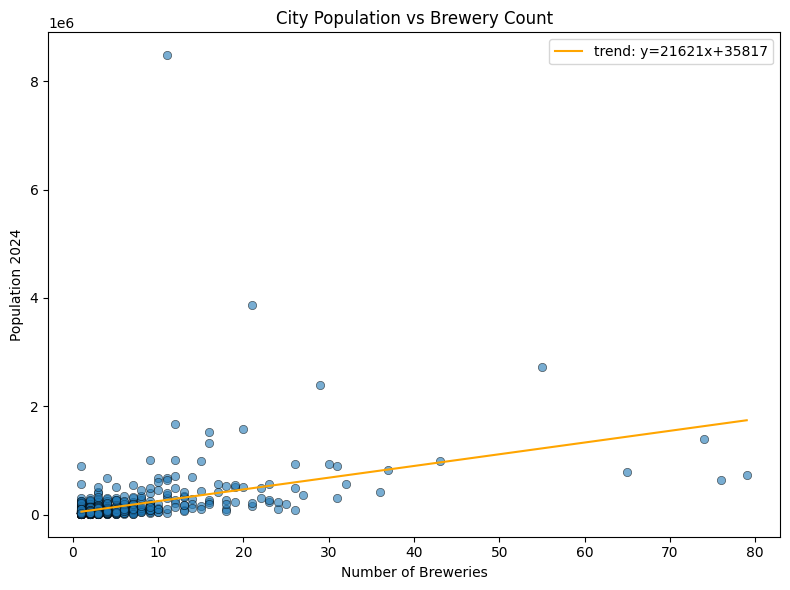

In [343]:
plot_data = breweries_per_city[['brewery_count', 'Population 2024']].dropna()
x = plot_data['brewery_count'].astype(float)
y = plot_data['Population 2024'].astype(float)
coef = np.polyfit(x, y, 1) if len(plot_data) >= 2 else (0, y.mean() if len(plot_data) else 0)
x_line = np.linspace(x.min(), x.max(), 100) if len(plot_data) >= 2 else x
y_line = coef[0] * x_line + coef[1] if len(plot_data) >= 2 else y
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.6, edgecolor='k', linewidth=0.5)
if len(plot_data) >= 2:
    plt.plot(x_line, y_line, color="orange", label=f"trend: y={coef[0]:.0f}x+{coef[1]:.0f}")
plt.xlabel('Number of Breweries')
plt.ylabel('Population 2024')
plt.title('City Population vs Brewery Count')
if len(plot_data) >= 2:
    plt.legend()
plt.tight_layout()
plt.show()


### Breweries Per Capita
Rank cities by breweries per 100k residents to surface locations that are unusually brewery-dense or brewery-scarce relative to their population.


In [344]:
# calculate breweries per 100k so we can look at density instead of raw counts
per_capita_df = breweries_per_city.copy()
per_capita_df['breweries_per_100k'] = (per_capita_df['brewery_count'] / per_capita_df['Population 2024']) * 100000
per_capita_df = per_capita_df.sort_values('breweries_per_100k', ascending=False).reset_index(drop=True)
top_per_capita = per_capita_df.head(10)[['city', 'state', 'brewery_count', 'Population 2024', 'breweries_per_100k']]
bottom_per_capita = per_capita_df.tail(10)[['city', 'state', 'brewery_count', 'Population 2024', 'breweries_per_100k']]
print('Top 10 cities by breweries per 100k residents:')
display(top_per_capita)
print('Bottom 10 cities by breweries per 100k residents:')
display(bottom_per_capita)


Top 10 cities by breweries per 100k residents:


city           state  brewery_count  Population 2024  \
0            Golden        Colorado              7          20151.0   
1  South Lake Tahoe      California              7          21225.0   
2           Holland        Michigan             11          35023.0   
3    Fredericksburg        Virginia              9          29992.0   
4         Asheville  North Carolina             26          94992.0   
5        Portsmouth   New Hampshire              6          22938.0   
6          Portland           Maine             18          69568.0   
7          Roseburg          Oregon              6          23795.0   
8            Naples         Florida              5          20168.0   
9      Phoenixville    Pennsylvania              5          20286.0   

   breweries_per_100k  
0           34.737730  
1           32.979976  
2           31.407932  
3           30.008002  
4           27.370726  
5           26.157468  
6           25.873965  
7           25.215381  
8           24.791749  
9           24.647540

Bottom 10 cities by breweries per 100k residents:


city           state  brewery_count  \
1130                     Yonkers        New York              1   
1131                 Baton Rouge       Louisiana              1   
1132               Santa Clarita      California              1   
1133                  Chesapeake        Virginia              1   
1134               Winston-Salem  North Carolina              1   
1135                      Irving           Texas              1   
1136                 Jersey City      New Jersey              1   
1137  Los Ranchos de Albuquerque      New Mexico              1   
1138                    New York        New York             11   
1139                INDIANAPOLIS         Indiana              1   

      Population 2024  breweries_per_100k  
1130         211040.0            0.473844  
1131         220907.0            0.452679  
1132         229159.0            0.436378  
1133         254997.0            0.392161  
1134         255769.0            0.390978  
1135         258060.0            0.387507  
1136         302824.0            0.330225  
1137         560326.0            0.178468  
1138        8478072.0            0.129746  
1139         891484.0            0.112173

### Population vs Breweries (Hexbin Density)
Convert the scatter into a hexbin density map so overlapping cities become visible and we can see where most cities cluster in the population/brewery space.


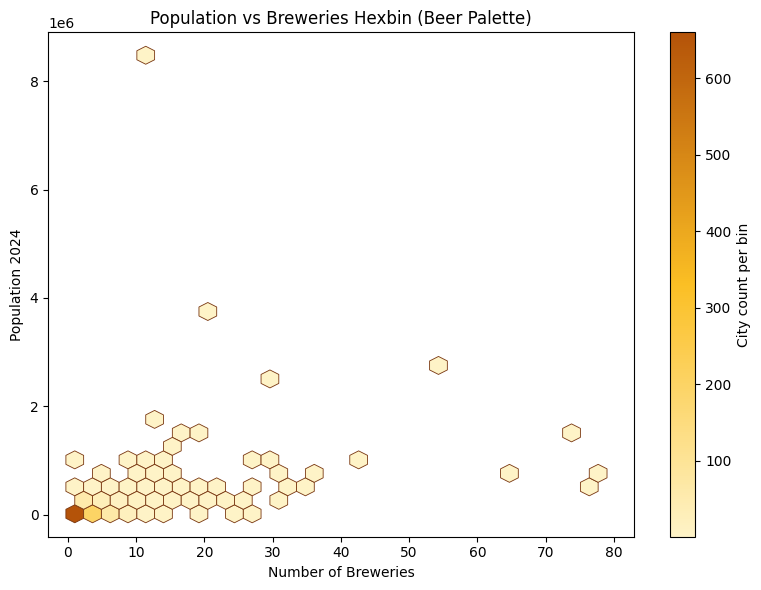

In [345]:
# hexbin to keep the scatter readable when lots of cities overlap
plot_data = breweries_per_city[['brewery_count', 'Population 2024']].dropna()
amber_palette = ['#fef3c7', '#fbbf24', '#b45309']
amber_cmap = LinearSegmentedColormap.from_list('amber', amber_palette)
plt.figure(figsize=(8, 6))
hb = plt.hexbin(
    plot_data['brewery_count'],
    plot_data['Population 2024'],
    gridsize=30,
    cmap=amber_cmap,
    mincnt=1,
    linewidths=0.6,
    edgecolors='#78350f'
)
plt.colorbar(hb, label='City count per bin')
plt.xlabel('Number of Breweries')
plt.ylabel('Population 2024')
plt.title('Population vs Breweries Hexbin (Beer Palette)')
plt.tight_layout()
Path('plots').mkdir(exist_ok=True)
plt.savefig(Path('plots') / 'population_vs_breweries_hexbin.png', dpi=150)
plt.show()


### Log-Scale Relationship
Plot the same relationship on log scales to dampen the effect of very large and very small cities and check for a proportional trend.


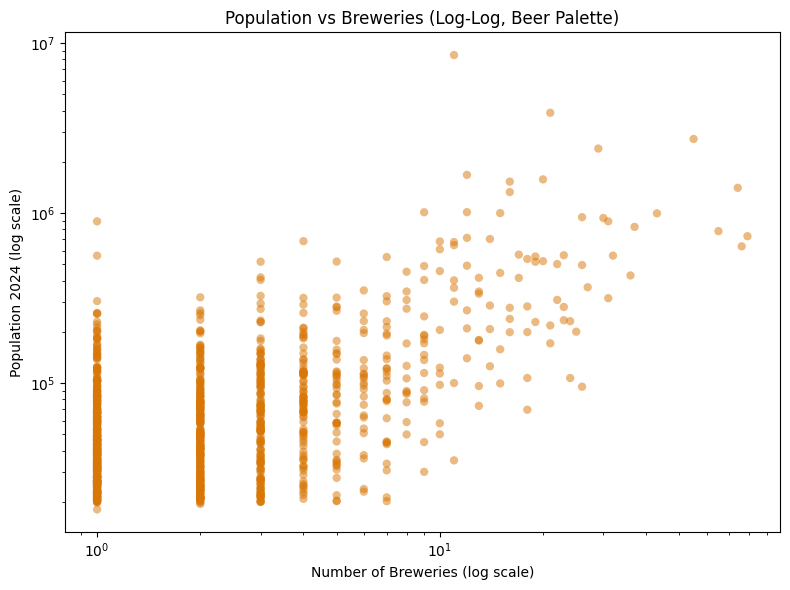

In [346]:
# log-log view to smooth out skew
log_data = breweries_per_city[['brewery_count', 'Population 2024']].dropna()
log_data = log_data[(log_data['brewery_count'] > 0) & (log_data['Population 2024'] > 0)]
plt.figure(figsize=(8, 6))
plt.scatter(log_data['brewery_count'], log_data['Population 2024'], alpha=0.5, edgecolor='none', color='#d97706')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Breweries (log scale)')
plt.ylabel('Population 2024 (log scale)')
plt.title('Population vs Breweries (Log-Log, Beer Palette)')
plt.tight_layout()
Path('plots').mkdir(exist_ok=True)
plt.savefig(Path('plots') / 'population_vs_breweries_loglog.png', dpi=150)
plt.show()


### Population Band Summary
Bucket cities into population bands, compute average brewery counts within each bucket, and display the results to see how brewery presence shifts with city size.


/var/folders/kf/7v3ct9jn3gl0w0_dqt8rml7c0000gn/T/ipykernel_52100/23960034.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  per_capita_df.groupby('population_band')


population_band  avg_breweries  avg_per_100k  city_count
0           <100k       2.225118      5.413833         844
1        100-250k       4.640777      3.147976         206
2        250-500k       9.960784      2.883172          51
3         500k-1M      22.821429      3.278078          28
4            1-2M      22.714286      1.656080           7
5            2-5M      35.000000      1.258610           3
6             >5M      11.000000      0.129746           1

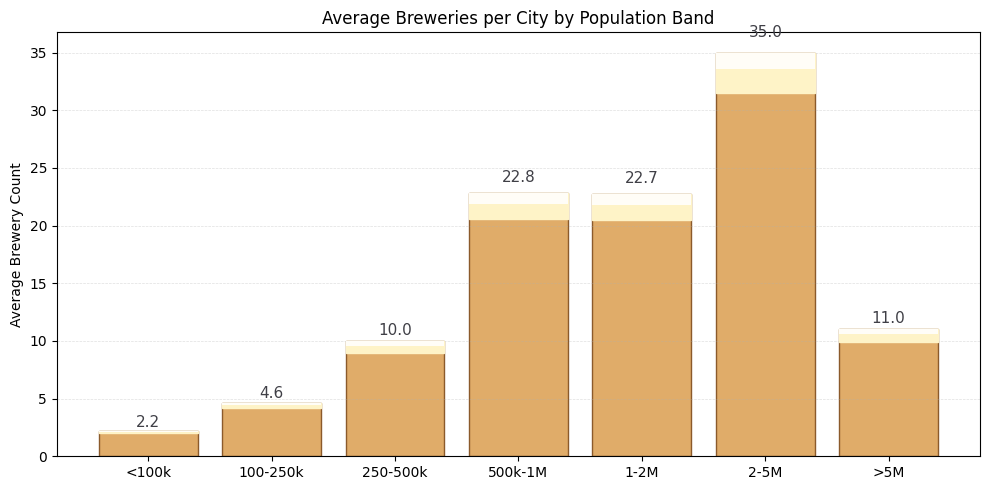

In [347]:
# organize cities into population bands and see how brewery counts average out
bins = [0, 100000, 250000, 500000, 1000000, 2000000, 5000000, np.inf]
labels = ['<100k', '100-250k', '250-500k', '500k-1M', '1-2M', '2-5M', '>5M']
per_capita_df = per_capita_df.copy()
per_capita_df['population_band'] = pd.cut(per_capita_df['Population 2024'], bins=bins, labels=labels, right=False)
band_summary = (
    per_capita_df.groupby('population_band')
    .agg(avg_breweries=('brewery_count', 'mean'),
         avg_per_100k=('breweries_per_100k', 'mean'),
         city_count=('city', 'count'))
    .reset_index()
)
display(band_summary)
fig, ax = plt.subplots(figsize=(10, 5))

bars = ax.bar(band_summary['population_band'], band_summary['avg_breweries'], color='#e0ac69', edgecolor='#8b5a2b')
for bar in bars:
    height = float(bar.get_height())
    width = bar.get_width()
    x = bar.get_x()
    if height <= 0:
        continue
    if height < 0.2:
        foam_height = height
        foam_base = 0.0
    else:
        foam_height = max(height * 0.1, 0.2)
        foam_base = height - foam_height
    ax.add_patch(Rectangle((x, foam_base), width, foam_height, facecolor='#fef3c7', edgecolor='#fef3c7', zorder=3))
    ax.add_patch(Rectangle((x, foam_base + foam_height * 0.6), width, foam_height * 0.4, facecolor='#fffdf7', edgecolor='none', zorder=4))
    ax.text(x + width / 2, height + max(height * 0.03, 0.05), '{:.1f}'.format(height), ha='center', va='bottom', fontsize=11, color='#3f3f46')
ax.set_ylabel('Average Brewery Count')
ax.set_title('Average Breweries per City by Population Band')
ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.4)
plt.tight_layout()
Path('plots').mkdir(exist_ok=True)
plt.savefig(Path('plots') / 'average_breweries_population_band.png', dpi=150)
plt.show()


### Brewery Density Heatmap
Project per-capita brewery intensity onto a folium heat map so we can inspect geographic hotspots and gaps at a glance.


In [348]:
city_coords = df_geo.groupby(['city', 'state'], as_index=False)[['latitude', 'longitude']].mean()
heat_source = per_capita_df.merge(city_coords, on=['city', 'state'], how='inner')
heat_source = heat_source.dropna(subset=['latitude', 'longitude', 'breweries_per_100k'])
heat_weights = heat_source['breweries_per_100k']
max_weight = heat_weights.max() if not heat_weights.empty else 1
heat_data = [
    [row.latitude, row.longitude, row.breweries_per_100k / max_weight]
    for row in heat_source.itertuples()
]
heat_center = [df_geo['latitude'].mean(), df_geo['longitude'].mean()]
heat_gradient = {0.0: '#0f172a', 0.3: '#1f2937', 0.5: '#fbbf24', 0.75: '#f97316', 1.0: '#b45309'}
Path('maps').mkdir(exist_ok=True)
heat_map = folium.Map(location=heat_center, tiles='CartoDB positron', zoom_start=4)
HeatMap(heat_data, radius=16, blur=24, min_opacity=0.3, gradient=heat_gradient).add_to(heat_map)
heat_map.save(Path('maps') / 'brewery_heatmap.html')
heat_map


### Correlation Summary & Residuals
Summarize linear and rank correlations and inspect the residuals from a simple regression to quantify how tightly population alone explains brewery counts.


metric         value
0   pearson_corr  4.195384e-01
1  spearman_corr  4.325231e-01
2  residual_mean  4.043901e-11
3   residual_std  3.005900e+05

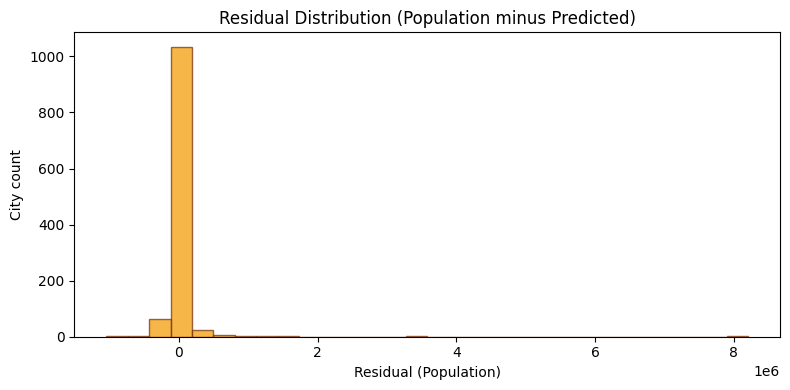

In [349]:
# quick stats to see how tightly population and brewery count are correlated
plot_data = breweries_per_city[['brewery_count', 'Population 2024']].dropna()
pearson_corr = plot_data['brewery_count'].corr(plot_data['Population 2024'], method='pearson')
spearman_corr = plot_data['brewery_count'].corr(plot_data['Population 2024'], method='spearman')
coef = np.polyfit(plot_data['brewery_count'], plot_data['Population 2024'], 1)
predicted = np.polyval(coef, plot_data['brewery_count'])
residuals = plot_data['Population 2024'] - predicted
summary_df = pd.DataFrame({
    'metric': ['pearson_corr', 'spearman_corr', 'residual_mean', 'residual_std'],
    'value': [pearson_corr, spearman_corr, residuals.mean(), residuals.std()]
})
display(summary_df)
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=30, color='#f59e0b', alpha=0.75, edgecolor='#78350f')
plt.title('Residual Distribution (Population minus Predicted)')
plt.xlabel('Residual (Population)')
plt.ylabel('City count')
plt.tight_layout()
Path('plots').mkdir(exist_ok=True)
plt.savefig(Path('plots') / 'population_vs_breweries_residuals.png', dpi=150)
plt.show()


## Brewery Count Extremes

Plot top ten cities with most breweries as bar chart to visualize extremes.

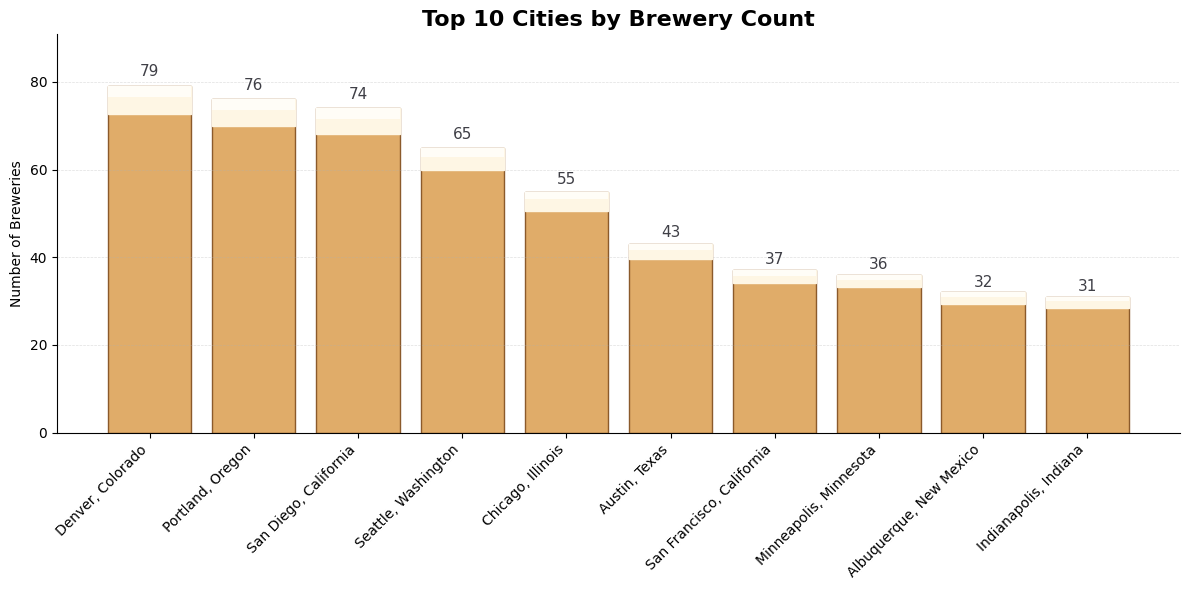

In [350]:
# plot the top 10 brewery cities
top10 = breweries_per_city.sort_values('brewery_count', ascending=False).head(10).copy()
top_labels = top10.apply(lambda row: f"{row['city']}, {row['state']}", axis=1)
counts = top10['brewery_count'].to_numpy()

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(top_labels, counts, color='#e0ac69', edgecolor='#8b5a2b')

for bar in bars:
    height = bar.get_height()
    x = bar.get_x()
    width = bar.get_width()
    foam_height = min(max(height * 0.08, 0.4), height)
    foam_base = height - foam_height
    ax.add_patch(Rectangle((x, foam_base), width, foam_height, facecolor='#fef6e4', edgecolor='#fef6e4', zorder=3))
    ax.add_patch(Rectangle((x, foam_base + foam_height * 0.6), width, foam_height * 0.4, facecolor='#fffdf7', edgecolor='none', zorder=4))
    ax.text(bar.get_x() + width / 2, height + max(height * 0.02, 0.3),
            '{:.0f}'.format(height), ha='center', va='bottom', fontsize=11, color='#3f3f46')

ax.set_title('Top 10 Cities by Brewery Count', fontsize=16, fontweight='bold')
ax.set_ylabel('Number of Breweries')
ax.set_ylim(0, counts.max() * 1.15)
ax.tick_params(axis='x', rotation=45)
for label in ax.get_xticklabels():
    label.set_ha('right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.4)
plt.tight_layout()
Path('plots').mkdir(exist_ok=True)
plt.savefig(Path('plots') / 'top10_breweries_bar.png', dpi=150)
plt.show()


## Geo Cleanup
Convert latitude/longitude columns to numeric, remove rows outside a broad US bounding box, and prepare a GeoDataFrame for mapping and routing.


In [351]:
# convert coords to numeric and drop anything obviously off the map
df_geo = df_clean.copy()
df_geo['latitude'] = pd.to_numeric(df_geo['latitude'], errors='coerce')
df_geo['longitude'] = pd.to_numeric(df_geo['longitude'], errors='coerce')
missing_coords_mask = df_geo['latitude'].isna() | df_geo['longitude'].isna()
removed_missing_coords = int(missing_coords_mask.sum())
df_geo = df_geo.loc[~missing_coords_mask].copy()
valid_lat = df_geo['latitude'].between(18, 72)
valid_lon = df_geo['longitude'].between(-170, -60)
valid_mask = valid_lat & valid_lon
removed_outliers = int((~valid_mask).sum())
df_geo = df_geo.loc[valid_mask].copy()
print(f'Removed {removed_missing_coords} breweries without latitude/longitude.')
print(f'Removed {removed_outliers} breweries outside continental/territorial bounds.')
print(f'Brewery records remaining after geo filter: {len(df_geo):,}')
df_geo.head()


Removed 1703 breweries without latitude/longitude.
Removed 2 breweries outside continental/territorial bounds.
Brewery records remaining after geo filter: 5,372


id                            name  \
0   5128df48-79fc-4f0f-8b52-d06be54d0cec                (405) Brewing Co   
2   34e8c68b-6146-453f-a4b9-1f6cd99a5ada         1 of Us Brewing Company   
10  1ecc330f-6275-42a5-b14e-00adbed62752  10 Torr Distilling and Brewing   
11  7531dbd8-afc9-4b5b-95bc-7ece7f2c0bf3           10-56 Brewing Company   
13  4ffda196-dd59-44a5-9eeb-5f7fd4b58f5a             105 West Brewing Co   

   brewery_type            address_1 address_2  address_3            city  \
0         micro       1716 Topeka St       NaN        NaN          Norman   
2         micro  8100 Washington Ave       NaN        NaN  Mount Pleasant   
10        micro          490 Mill St       NaN        NaN            Reno   
11        micro        400 Brown Cir       NaN        NaN            Knox   
13        micro         1043 Park St       NaN        NaN     Castle Rock   

   state_province postal_code        country   longitude   latitude  \
0        Oklahoma  73069-8224  United States  -97.468182  35.257389   
2       Wisconsin  53406-3920  United States  -87.883364  42.720108   
10         Nevada       89502  United States -119.773201  39.517170   
11        Indiana       46534  United States  -86.627954  41.289715   
13       Colorado  80109-1585  United States -104.866721  39.382695   

         phone                    website_url      state               street  
0   4058160490      http://www.405brewing.com   Oklahoma       1716 Topeka St  
2   2624847553   https://www.1ofusbrewing.com  Wisconsin  8100 Washington Ave  
10  7755307014          http://www.10torr.com     Nevada          490 Mill St  
11  6308165790                            NaN    Indiana        400 Brown Cir  
13  3033257321  http://www.105westbrewing.com   Colorado         1043 Park St

## Brewery Locations Map
Render all valid breweries in USA on a folium base map as a sanity check that the geographic cleanup left us with plausible locations.


In [352]:
if df_geo.empty:
    raise ValueError('No brewery locations available after cleaning.')
center = [df_geo['latitude'].mean(), df_geo['longitude'].mean()]
Path('maps').mkdir(exist_ok=True)
brewery_map = folium.Map(location=center, tiles='CartoDB positron', zoom_start=4)
for row in df_geo.itertuples():
    folium.CircleMarker(
        location=(row.latitude, row.longitude),
        radius=3,
        color='#e0ac69',
        fill=True,
        fill_opacity=0.4
    ).add_to(brewery_map)
brewery_map.save(Path('maps') / 'all_breweries_map.html')
brewery_map


# TSP Approach for Breweries

To identify the best brewery route, this was approached like a TSP problem. First, you identify the start and end breweries then build a greedy path that always hops to the nearest unvisited brewery so the algorithm stays fast even with a few thousand points. That path then feeds a Lin–Kernighan–style 2‑opt refinement loop, which keeps the endpoints fixed and repeatedly un-crosses segments whenever it finds a shorter swap. The end result is an ordered list of breweries, the cumulative mileage between them, and a “closest_brewery” column on each stop that explains the next leg. For testing a Los Angeles subset was chosen but this can be ran for any two points in the dataset.

In [353]:
# TSP-style helper functions and path builder live below
EARTH_RADIUS_MI = 3958.8

# distance helper to convert lat/lon hops into miles
def haversine_miles(lat1, lon1, lat2, lon2):
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return EARTH_RADIUS_MI * c

# format the brewery city/state label for later
def format_brewery_label(row):
    parts = [str(row['name']).strip()]
    location_parts = []
    if pd.notna(row.get('city')) and str(row['city']).strip():
        location_parts.append(str(row['city']).strip())
    if pd.notna(row.get('state')) and str(row['state']).strip():
        location_parts.append(str(row['state']).strip())
    if location_parts:
        parts.append(', '.join(location_parts))
    return ' - '.join(parts)

# basic 2-opt refinement loop to un-cross segments
def lin_kernighan_refine_positions(path_positions, coords, max_iterations=10, tolerance=1e-6):
    n = len(path_positions)
    if n < 4:
        return path_positions
    iteration = 0
    improved = True
    while improved and iteration < max_iterations:
        improved = False
        iteration += 1
        for i in tqdm(range(1, n - 2), desc=f'LK iter {iteration}', leave=False):
            for j in range(i + 1, n - 1):
                a = path_positions[i - 1]
                b = path_positions[i]
                c = path_positions[j]
                d = path_positions[j + 1]
                dist_before = haversine_miles(coords[a, 0], coords[a, 1], coords[b, 0], coords[b, 1]) + haversine_miles(coords[c, 0], coords[c, 1], coords[d, 0], coords[d, 1])
                dist_after = haversine_miles(coords[a, 0], coords[a, 1], coords[c, 0], coords[c, 1]) + haversine_miles(coords[b, 0], coords[b, 1], coords[d, 0], coords[d, 1])
                if dist_after + tolerance < dist_before:
                    path_positions[i : j + 1] = list(reversed(path_positions[i : j + 1]))
                    improved = True
        if not improved:
            break
    return path_positions

# main greedy and lin kernigan path builder to walk every brewery between start/end while trimming crossings
def build_brewery_path(df, start_idx, end_idx):
    if start_idx not in df.index:
        raise KeyError('Start index not found in dataframe')
    if end_idx not in df.index:
        raise KeyError('End index not found in dataframe')
    if start_idx == end_idx:
        raise ValueError('Start and end breweries must be different')

    work_df = df.copy()
    work_df['closest_brewery'] = pd.NA
    work_df['distance_to_closest_brewery'] = pd.NA

    indices = work_df.index.to_numpy()
    pos_lookup = {idx: pos for pos, idx in enumerate(indices)}
    coords = work_df[['latitude', 'longitude']].to_numpy()

    start_pos = pos_lookup[start_idx]
    end_pos = pos_lookup[end_idx]
    remaining = set(range(len(indices)))
    remaining.discard(start_pos)
    forced_end = None
    if end_pos in remaining:
        remaining.remove(end_pos)
        forced_end = end_pos

# greedy walk to cover every brewery once before refinement
    path_positions = [start_pos]
    current_pos = start_pos
    greedy_progress = tqdm(total=len(remaining), desc='Greedy build', leave=False)
    while remaining:
        remaining_array = np.fromiter(remaining, dtype=int)
        distances = haversine_miles(
            coords[current_pos, 0],
            coords[current_pos, 1],
            coords[remaining_array, 0],
            coords[remaining_array, 1]
        )
        next_pos = int(remaining_array[int(np.argmin(distances))])
        path_positions.append(next_pos)
        remaining.remove(next_pos)
        current_pos = next_pos
        greedy_progress.update(1)
    greedy_progress.close()

    if forced_end is not None:
        if current_pos != forced_end:
            path_positions.append(forced_end)
    elif current_pos != end_pos:
        path_positions.append(end_pos)

    path_positions = lin_kernighan_refine_positions(path_positions, coords)
    path_indices = [indices[pos] for pos in path_positions]

# fill in closest-brewery metadata and total mileage for the final path
    total_distance = 0.0
    for i in range(len(path_indices) - 1):
        curr_idx = path_indices[i]
        next_idx = path_indices[i + 1]
        curr_pos = pos_lookup[curr_idx]
        next_pos = pos_lookup[next_idx]
        distance = float(haversine_miles(
            coords[curr_pos, 0], coords[curr_pos, 1],
            coords[next_pos, 0], coords[next_pos, 1]
        ))
        work_df.loc[curr_idx, 'closest_brewery'] = format_brewery_label(work_df.loc[next_idx])
        work_df.loc[curr_idx, 'distance_to_closest_brewery'] = distance
        total_distance += distance

    work_df.loc[path_indices[-1], 'closest_brewery'] = pd.NA
    work_df.loc[path_indices[-1], 'distance_to_closest_brewery'] = 0.0

    path_df = work_df.loc[path_indices, ['name', 'city', 'state', 'latitude', 'longitude', 'closest_brewery', 'distance_to_closest_brewery']].reset_index(drop=True)

    return {
        'path_df': path_df,
        'brewery_count': len(path_indices),
        'total_distance_miles': total_distance
    }

### Los Angeles Demo
Run the matching and path-building logic on Los Angeles only, which keeps the dataset small while we validate the route calculations and map output.


In [354]:
la_breweries = df_geo[df_geo['city'].str.strip().str.lower() == 'los angeles'].copy()
if la_breweries.empty:
    raise ValueError('No Los Angeles breweries found after cleaning.')
la_start = la_breweries.loc[la_breweries['latitude'].idxmax()].name
la_end = la_breweries.loc[la_breweries['latitude'].idxmin()].name
# demo the path builder on LA to prove it works before scaling up
la_result = build_brewery_path(la_breweries, la_start, la_end)
la_result['path_df'].head()
la_result['brewery_count'], la_result['total_distance_miles']


(20, 42.09302411997999)

In [355]:
# load the LA path into a map-friendly format
if la_result['path_df'].empty:
    raise ValueError('Los Angeles path dataframe is empty; cannot plot.')
# load the LA path into a map-friendly format
path_points = la_result['path_df'].copy()
center = [path_points['latitude'].mean(), path_points['longitude'].mean()]
Path('maps').mkdir(exist_ok=True)
la_map = folium.Map(location=center, tiles='CartoDB positron', zoom_start=11)
coordinates = list(zip(path_points['latitude'], path_points['longitude']))
folium.PolyLine(coordinates, color='black', weight=3, opacity=0.8).add_to(la_map)
# mark start/end points so the route direction is obvious
start_row = path_points.iloc[0]
end_row = path_points.iloc[-1]
folium.Marker(
    location=(start_row['latitude'], start_row['longitude']),
    icon=folium.Icon(color='green', icon='play'),
    popup='Start: {}'.format(start_row['name'])
).add_to(la_map)
folium.Marker(
    location=(end_row['latitude'], end_row['longitude']),
    icon=folium.Icon(color='red', icon='flag'),
    popup='End: {}'.format(end_row['name'])
).add_to(la_map)
beer_icon_html = '<div style="font-size: 16px;">🍺</div>'
for _, row in path_points.iterrows():
    folium.Marker(
        location=(row['latitude'], row['longitude']),
        icon=folium.DivIcon(html=beer_icon_html),
        popup=row['name']
    ).add_to(la_map)
la_map.save(Path('maps') / 'la_route_map.html')
la_map


In [359]:
# anchor points: most northern Maine brewery and most eastern Hawaii brewery
maine_breweries = df_geo[df_geo['state'].str.strip().str.lower() == 'maine']
hawaii_breweries = df_geo[df_geo['state'].str.strip().str.lower() == 'hawaii']
if maine_breweries.empty:
    raise ValueError('No Maine breweries found after cleaning.')
if hawaii_breweries.empty:
    raise ValueError('No Hawaii breweries found after cleaning.')
northernmost_maine = maine_breweries.loc[maine_breweries['latitude'].idxmax()]
easternmost_hawaii = hawaii_breweries.loc[hawaii_breweries['longitude'].idxmax()]
display_columns = ['name', 'city', 'state', 'latitude', 'longitude', 'brewery_type']
northernmost_maine[display_columns] if all(col in northernmost_maine for col in display_columns) else northernmost_maine
easternmost_hawaii[display_columns] if all(col in easternmost_hawaii for col in display_columns) else easternmost_hawaii

name            Hilo Brewing Co
city                       Hilo
state                    Hawaii
latitude              19.705876
longitude           -155.069788
brewery_type              micro
Name: 3545, dtype: object

In [360]:
maine_to_hawaii = build_brewery_path(df_geo, northernmost_maine.name, easternmost_hawaii.name)
maine_to_hawaii['path_df'].head()

name        city  state  \
0                          Northern Maine Brewing Co     Caribou  Maine   
1                                   Lubec Brewing Co       Lubec  Maine   
2                      Machias River Brewing Company     Machias  Maine   
3           Atlantic Brewing Co / Bar Harbor Brewing  Bar Harbor  Maine   
4  Jack Russell's Steakhouse and Brewery / Maine ...  Bar Harbor  Maine   

    latitude  longitude                                    closest_brewery  \
0  46.814077 -67.996710                    Lubec Brewing Co - Lubec, Maine   
1  44.860831 -66.983481     Machias River Brewing Company - Machias, Maine   
2  44.714463 -67.458046  Atlantic Brewing Co / Bar Harbor Brewing - Bar...   
3  44.389488 -68.206071  Jack Russell's Steakhouse and Brewery / Maine ...   
4  44.394650 -68.223187         Fogtown Brewing Company - Ellsworth, Maine   

  distance_to_closest_brewery  
0                  143.497532  
1                   25.373972  
2                   43.135391  
3                    0.917238  
4                   14.097148

In [361]:
maine_to_hawaii['brewery_count'], result['total_distance_miles']

(5372, 73352.57389458665)